In [ ]:
!pip install patchify

In [ ]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import matplotlib.pyplot as plt
import seaborn as sns
from patchify import patchify
import tifffile as tiff
from skimage import io
import pickle

import random
random.seed(100)

print('tensorflow version',tf.__version__)
print('keras version', keras.__version__)
%matplotlib inline

tensorflow version 2.8.0
keras version 2.8.0


**Loading Data**

In [ ]:
images = np.load('/content/drive/MyDrive/seismic-facies-identification-dataset/data_train.npz', allow_pickle=True, mmap_mode='r')['data']
masks = np.load('/content/drive/MyDrive/seismic-facies-identification-dataset/labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']

# The images are saved in the numpy format (.npz), which we import using the np.load function and use for modeling.

In [ ]:
print('shape of the images:',images.shape)
print('shape of the  masks:', masks.shape)

shape of the images: (1006, 782, 590)
shape of the  masks: (1006, 782, 590)


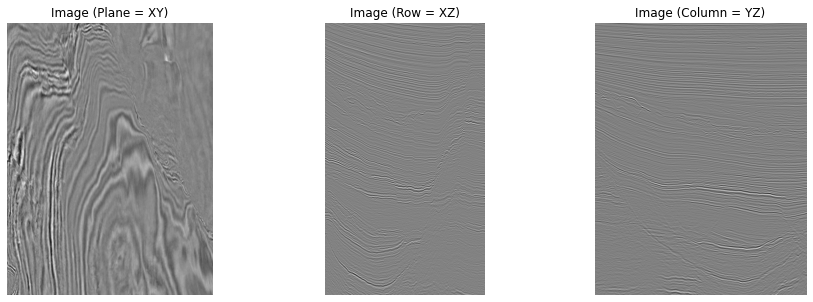

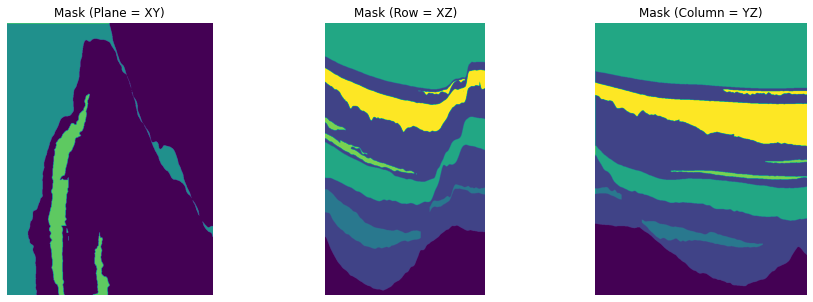

In [ ]:
def show_image_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)


(n_plane, n_row, n_col) = images.shape
_, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

show_image_plane(a, images[n_plane // 2], title=f'Image (Plane = XY)')
show_image_plane(b, images[:, n_row // 2, :], title=f'Image (Row = XZ)')
show_image_plane(c, images[:, :, n_col // 2], title=f'Image (Column = YZ)')

(n_plane, n_row, n_col) = masks.shape
_, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

show_image_plane(a, masks[n_plane // 2], title=f'Mask (Plane = XY)',cmap=None)
show_image_plane(b, masks[:, n_row // 2, :], title=f'Mask (Row = XZ)',cmap=None)
show_image_plane(c, masks[:, :, n_col // 2], title=f'Mask (Column = YZ)',cmap=None)

**Distribution of Class Lables**

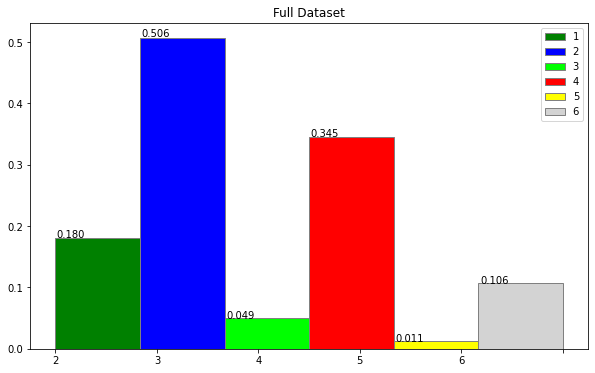

In [ ]:
def label_distibution_plot(df, title='Full Dataset'):
    fig = plt.figure(figsize=(10,6))
    labels    = list(range(1,7))
    colors = ['green', 'blue', 'lime', 'red', 'yellow', 'lightgrey']
    N, bins, patches = plt.hist(df.flatten(),6,density=True, edgecolor='gray', linewidth=1)
    for i in range(6):
        patches[i].set_facecolor(colors[i])
        patches[i].set_label(labels[i])
    plt.gca().axes.xaxis.set_ticklabels(list(range(1,7)))
    for p in patches:
        plt.annotate(str(p.get_height())[:5], (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.title(title)
    plt.legend()
    plt.show()

label_distibution_plot(masks)

**Data Pre-Processing**

In [ ]:
mean, std = images.mean(), images.std()
min, max = images.min(), images.max()

print('image properties..')
print('mean:',mean)
print('std:',std)
print('min_pixel - max_pixel:',min,'-',max)

image properties..
mean: 0.67661
std: 390.30884
min_pixel - max_pixel: -5195.5234 - 5151.7188


**MIN-MAX Scaling**

In [ ]:
images = (images - min)/(max - min) #min-max scaler

# we scaled the pixel values in range between -1 to +1

**Patches Generation**

In [ ]:
# generating patches from images
'''for img in range(images.shape[0]):

    large_image = images[img]
    
    patches_img = patchify(large_image, (512, 512), step=512)  #Step=512 for 512 patches means no overlap
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            np.save('/content/drive/MyDrive/patches/images/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".npz", single_patch_img)'''

In [ ]:
# generating patches from masks
'''for msk in range(masks.shape[0]):
     
    large_mask = masks[msk]
    
    patches_mask = patchify(large_mask, (512, 512), step=512)  
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            np.save('/content/drive/MyDrive/patches/masks/' + 'mask_' + str(msk) + '_' + str(i)+str(j)+ ".npz", single_patch_mask)
            single_patch_mask = single_patch_mask / 255'''

In [ ]:
print('shape of the image patches folder:', len(os.listdir('/content/drive/MyDrive/patches/images')))
print('shape of the mask patches folder:', len(os.listdir('/content/drive/MyDrive/patches/masks')))

shape of the image patches folder: 1006
shape of the mask patches folder: 1006


**Stacking the patches**

In [ ]:
def stack_patches(directory):

  data = []

  for path in os.listdir(directory):
    val = np.load(os.path.join(directory,path), allow_pickle=True, mmap_mode='r')
    data.append(val)
  to_array = np.array(data)
  return to_array

images_stacked = stack_patches('/content/drive/MyDrive/patches/images')
masks_stacked  = stack_patches('/content/drive/MyDrive/patches/masks')

print('shape of images after stacking', images_stacked.shape)
print('shape of masks after stacking', images_stacked.shape)

shape of images after stacking (1006, 512, 512)
shape of masks after stacking (1006, 512, 512)


**Displaying a Random Patch of `Image` and corresponding `Mask`**

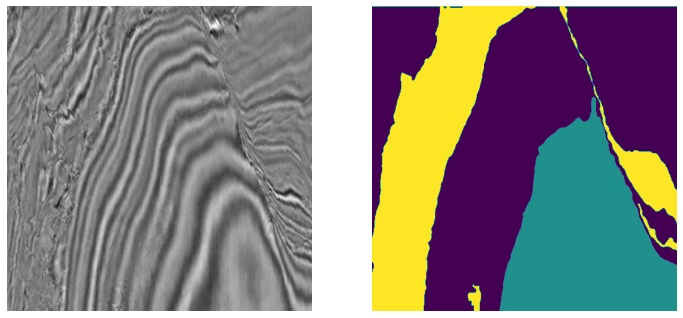

In [ ]:
def display_random_patch():
      image_number = random.randint(0, images_stacked.shape[0])
      plt.figure(figsize=(12, 6))
      plt.subplot(121)
      plt.imshow(np.reshape(images_stacked[image_number], (512, 512)), cmap='gray')
      plt.axis('off')
      plt.subplot(122)
      plt.imshow(np.reshape(masks_stacked[image_number], (512, 512)))
      plt.axis('off')
      plt.show()

display_random_patch()

In [ ]:
image_dataset = np.expand_dims(images_stacked, 3)

In [ ]:
mask_dataset = np.expand_dims(masks_stacked, 3)

**Label Encoding**

In [ ]:
labelencoder = LabelEncoder()
n, h, w =  masks_stacked.shape
train_masks_reshaped = masks_stacked.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
mask_dataset = train_masks_reshaped_encoded.reshape(n, h, w)

**Class Weights**

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = [0,1,2,3,4,5],
                                                 y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [ 1.01833657  0.37961082  3.34285935  0.61222313 18.06211106  2.52634665]


**Train-Test Split (70:30)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.30, random_state = 45)

**Distridution of labels amoung train test split labels**

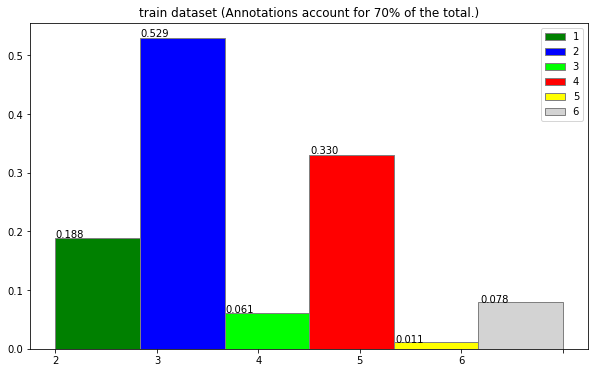

In [ ]:
label_distibution_plot(y_train, title='train dataset (Annotations account for 70% of the total.)')

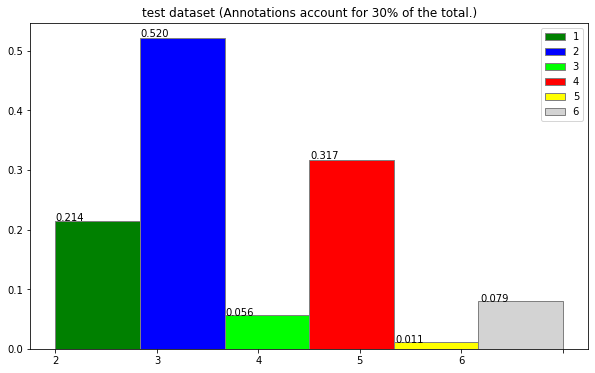

In [ ]:
label_distibution_plot(y_test, title='test dataset (Annotations account for 30% of the total.)')

**One-Hot Encodeing of Class Labels**

In [ ]:
n_classes = 6
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [ ]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

**Saving Train and Test data on drive for modeling**

In [ ]:
#np.save('/content/drive/MyDrive/seismic_facies_train_test_data/X_train',X_train)
#np.save('/content/drive/MyDrive/seismic_facies_train_test_data/y_train',y_train_cat)
#np.save('/content/drive/MyDrive/seismic_facies_train_test_data/X_test',X_test)
#np.save('/content/drive/MyDrive/seismic_facies_train_test_data/y_test',y_test_cat)